# 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 회귀 모델

## 데이터 준비하기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

import warnings
warnings.filterwarnings('ignore')

dataset_path = tf.keras.utils.get_file('auto-mpg.data', 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', #연비, 실린더, 배수량, 마력, 중력,
                'Acceleration', 'Model Year', 'Origin']                 #가속, 연식, 제조국(1;USA, 2;Europe, 3;Japan)

raw_dataset = pd.read_csv(dataset_path, names=column_names, sep=' ', comment='\t',
                          na_values='?', skipinitialspace= True) # 데이터를 가져오고 이름달아주기, 공백으로 나누어져있다는 것을 알려줌 (데이터 확인해보기), tap키는 주석으로 간주하겠다. null data는 ?로 채워주기

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


## 데이터 전처리

### 누락된 행 삭제

In [ ]:
# Null 데이터 확인
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset = dataset.dropna()
dataset.isna().sum() # 검증

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

## 제조국 범주형 인코딩

In [ ]:
dataset['Origin'].value_counts() # 라벨링이 되어진 상태

1    245
3     79
2     68
Name: Origin, dtype: int64

In [ ]:
# 제조국끼리 비교 할 수 있도록 컬럼으로 범주화(원-핫 인코딩)
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0 # 해당되는 애들만 1, 나머지는 0으로 채워짐.
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 훈련데이터와 테스트데이터로 분할

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=7) # 80% 임의로 추출
test_dataset = dataset.drop(train_dataset.index) # 20%만 남겨서 테스트셋에 담기

In [ ]:
train_dataset.shape

(314, 10)

In [ ]:
test_dataset.shape

(78, 10)

### 특성과 타겟으로 분리

In [ ]:
데이터

In [ ]:
train_dataset.shape # 9개로 변함 -> MPG pop 시킴

(314, 9)

In [ ]:
test_dataset.shape

(78, 9)

### 데이터 표준화 (Standardization) 범위 축소

In [ ]:
mean = np.mean(train_dataset, axis=0)
std = np.std(train_dataset, axis=0)

train_dataset = (train_dataset-mean)/std
test_dataset = (test_dataset-mean)/std

train_dataset.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
36,0.34609,0.565723,-0.410067,0.406500,-0.029232,-1.380901,0.781189,-0.450627,-0.515877
311,-0.83513,-0.898649,-0.879426,-0.985151,-0.029232,1.096830,0.781189,-0.450627,-0.515877
278,-0.83513,-0.985356,-0.853350,-1.138209,-0.249521,0.546223,-1.280100,2.219128,-0.515877
125,0.34609,0.064754,-0.227538,0.171026,0.337917,-0.554991,0.781189,-0.450627,-0.515877
144,-0.83513,-1.110598,-1.348785,-1.539692,0.337917,-0.554991,-1.280100,-0.450627,1.938447


## 모델 구성하기

In [ ]:
len(train_dataset.keys())

9

In [ ]:
np.random.seed(7)

model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (len(train_dataset.keys()), )))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

## 모델 설정하기

In [ ]:
model.compile(optimizer=RMSprop(0.001), loss ='mse', metrics=['mae', 'mse'])

## 모델 학습하기

In [ ]:
history = model.fit(train_dataset, train_labels, epochs=500, validation_data=(test_dataset, test_labels))

Epoch 1/500
10/10 [==============================] - 1s 29ms/step - loss: 583.1232 - mae: 22.9004 - mse: 583.1232 - val_loss: 488.2823 - val_mae: 20.8588 - val_mse: 488.2823
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 516.8807 - mae: 21.4856 - mse: 516.8807 - val_loss: 427.2894 - val_mae: 19.4243 - val_mse: 427.2894
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 448.2235 - mae: 19.9243 - mse: 448.2235 - val_loss: 359.9203 - val_mae: 17.7088 - val_mse: 359.9203
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 371.0285 - mae: 18.0017 - mse: 371.0285 - val_loss: 286.4400 - val_mae: 15.6554 - val_mse: 286.4400
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 290.0116 - mae: 15.7608 - mse: 290.0116 - val_loss: 213.5947 - val_mae: 13.3152 - val_mse: 213.5947
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 210.3123 - mae: 13.2272 - mse: 210.3123 - val_loss: 145.4740 

## 모델 결과 분석

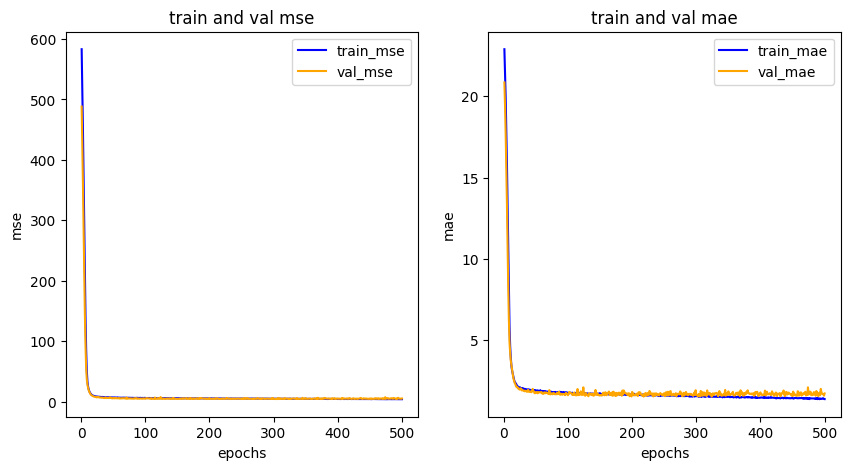

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
mse = his_dict['mse']
val_mse = his_dict['val_mse'] # 검증 데이터가 있는 경우 ‘val_’ 수식어가 붙습니다.

epochs = range(1, len(mse) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, mse, color = 'blue', label = 'train_mse')
ax1.plot(epochs, val_mse, color = 'orange', label = 'val_mse')
ax1.set_title('train and val mse')
ax1.set_xlabel('epochs')
ax1.set_ylabel('mse')
ax1.legend()

mae = his_dict['mae']
val_mae = his_dict['val_mae']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, color = 'blue', label = 'train_mae')
ax2.plot(epochs, val_mae, color = 'orange', label = 'val_mae')
ax2.set_title('train and val mae')
ax2.set_xlabel('epochs')
ax2.set_ylabel('mae')
ax2.legend()

plt.show()

## 모델 평가하기

In [ ]:
model.evaluate(test_dataset, test_labels) # 1.7 평균 절대 오차 -> 실제 연비와 1.7 차이

3/3 [==============================] - 0s 5ms/step - loss: 5.4223 - mae: 1.7314 - mse: 5.4223


[5.422280311584473, 1.731370210647583, 5.422280311584473]

3/3 [==============================] - 0s 3ms/step


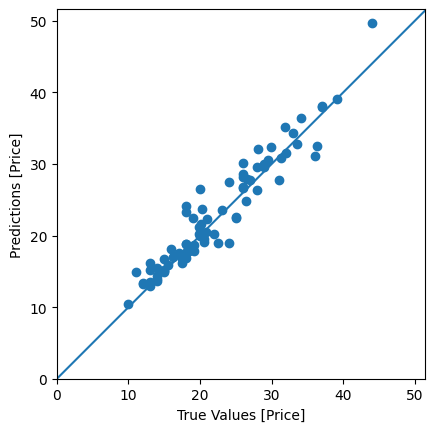

In [ ]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions) # (실제 정답, 모델 예측값)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])